## 6.2

**(a) Load the data**

**(b) A small percentage of cells in the predictor set contain missing values. Use an imputation function to fill in these missing values (e.g., see Sect. 3.8).**

**(c) Split the data into a training and a test set, pre-process the data, and tune a model of your choice from this chapter. What is the optimal value of the performance metric?**

**(d) Predict the response for the test set. What is the value of the performance metric and how does this compare with the resampled performance metric on the training set?**

**(e) Which predictors are most important in the model you have trained? Do either the biological or process predictors dominate the list?**

**(f) Explore the relationships between each of the top predictors and the response. How could this information be helpful in improving yield in future runs of the manufacturing process?**


In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import impute
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.stats import norm

from linearmodels import boxcox_transform, ols, pls, pca, penalised_regression

In [2]:
ds = pd.read_csv("data/ChemicalManufacturingProcess.csv", index_col="id", header=0)

In [3]:
ds.describe()

,Yield,BiologicalMaterial01,BiologicalMaterial02,BiologicalMaterial03,BiologicalMaterial04,BiologicalMaterial05,BiologicalMaterial06,BiologicalMaterial07,BiologicalMaterial08,BiologicalMaterial09,...,ManufacturingProcess36,ManufacturingProcess37,ManufacturingProcess38,ManufacturingProcess39,ManufacturingProcess40,ManufacturingProcess41,ManufacturingProcess42,ManufacturingProcess43,ManufacturingProcess44,ManufacturingProcess45
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,...,171.000000,176.000000,176.000000,176.000000,175.000000,175.000000,176.000000,176.000000,176.000000,176.000000
mean,40.176534,6.411420,55.688750,67.705000,12.349261,18.598636,48.910398,100.014148,17.494773,12.850057,...,0.019573,1.013636,2.534091,6.851136,0.017714,0.023714,11.206250,0.911932,1.805114,2.138068
std,1.845666,0.713923,4.034581,4.001064,1.774661,1.844141,3.746072,0.107742,0.676954,0.415176,...,0.000874,0.445083,0.649375,1.505494,0.038289,0.053824,1.941609,0.867986,0.322006,0.406904
min,35.250000,4.580000,46.870000,56.970000,9.380000,13.240000,40.600000,100.000000,15.880000,11.440000,...,0.017000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.752500,5.977500,52.680000,64.980000,11.245000,17.235000,46.055000,100.000000,17.060000,12.602500,...,0.019000,0.700000,2.000000,7.100000,0.000000,0.000000,11.400000,0.600000,1.800000,2.100000
50%,39.970000,6.305000,55.090000,67.220000,12.100000,18.490000,48.460000,100.000000,17.510000,12.835000,...,0.020000,1.000000,3.000000,7.200000,0.000000,0.000000,11.600000,0.800000,1.900000,2.200000
75%,41.475000,6.870000,58.737500,70.427500,13.220000,19.900000,51.345000,100.000000,17.880000,13.130000,...,0.020000,1.300000,3.000000,7.300000,0.000000,0.000000,11.700000,1.025000,1.900000,2.300000
max,46.340000,8.810000,64.750000,78.250000,23.090000,24.850000,59.380000,100.830000,19.140000,14.080000,...,0.022000,2.300000,3.000000,7.500000,0.100000,0.200000,12.100000,11.000000,2.100000,2.600000


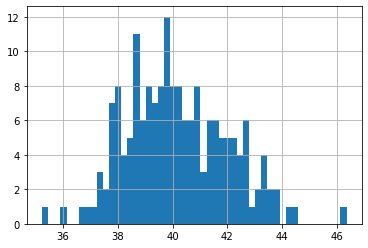

In [4]:
# Target var is relatively symmetric distribution
ds["Yield"].hist(bins=50)
plt.show()

In [5]:
ds["ManufacturingProcess27"].value_counts().sort_index()

0.0       1
4416.0    1
4423.0    1
4481.0    1
4518.0    1
         ..
4687.0    2
4692.0    1
4693.0    1
4696.0    2
4710.0    1
Name: ManufacturingProcess27, Length: 103, dtype: int64

In [6]:
normalised_ds=(ds-ds.mean())/ds.std()

In [7]:
normalised_ds.min().sort_values()[:20]

ManufacturingProcess18   -13.088362
ManufacturingProcess20   -13.055424
ManufacturingProcess16   -12.982189
ManufacturingProcess26   -12.940454
ManufacturingProcess25   -12.927496
ManufacturingProcess27   -12.888994
ManufacturingProcess31   -12.632749
ManufacturingProcess29   -12.026718
ManufacturingProcess30    -9.385892
ManufacturingProcess01    -6.149703
ManufacturingProcess42    -5.771630
ManufacturingProcess44    -5.605835
ManufacturingProcess45    -5.254474
ManufacturingProcess39    -4.550756
ManufacturingProcess09    -4.377868
ManufacturingProcess38    -3.902352
ManufacturingProcess34    -3.558813
BiologicalMaterial09      -3.396289
ManufacturingProcess04    -3.323233
ManufacturingProcess03    -3.105823
dtype: float64

In [8]:
# Manually checked, problem variables have value 0 as outliers:
outlier_vars = [
    "ManufacturingProcess18",
    "ManufacturingProcess20",
    "ManufacturingProcess16",
    "ManufacturingProcess26",
    "ManufacturingProcess25",
    "ManufacturingProcess27",
    "ManufacturingProcess31",
    "ManufacturingProcess29",
    "ManufacturingProcess30",
    "ManufacturingProcess01",
    "ManufacturingProcess42",
    "ManufacturingProcess44",
    "ManufacturingProcess45",
]

ds[outlier_vars] = ds[outlier_vars].replace(0, np.nan)
ds["ManufacturingProcess43"] = ds["ManufacturingProcess43"].replace(11, np.nan)
ds = ds.drop(columns="BiologicalMaterial07")
ds["ManufacturingProcess21"] = ds["ManufacturingProcess21"] + abs(ds["ManufacturingProcess21"].min())

In [9]:
ds = ds.replace(np.nan, ds.mean())

In [14]:
trials = 100
results = pd.DataFrame()

for i in range(trials):
    train_val, test = train_test_split(ds, test_size=0.2, random_state=i+trials)
    train, val = train_test_split(train_val, test_size=0.25, random_state=i+trials*2)
    ds_ = {}
    ds_["x_train"] = train.drop(columns="Yield")
    ds_["x_val"] = val.drop(columns="Yield")
    ds_["x_train_val"] = train_val.drop(columns="Yield")
    ds_["x_test"] = test.drop(columns="Yield")
    ds_["y_train"] = train["Yield"]
    ds_["y_val"] = val["Yield"]
    ds_["y_train_val"] = train_val["Yield"]
    ds_["y_test"] = test["Yield"]

    results = results.append({
        "ols":ols(ds_),
        "pca": pca(ds_),
        "pls": pls(ds_),
        "l1": penalised_regression(ds_, linear_model.Lasso),
        "l2": penalised_regression(ds_, linear_model.Ridge)
    }, ignore_index=True)
    print(i)

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.83188976842225, tolerance: 0.03742142990476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.832952971536105, tolerance: 0.03742142990476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.834836290497154, tolerance: 0.03742142990476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

0


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.971705920771466, tolerance: 0.040690922476190494
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.970531829786733, tolerance: 0.040690922476190494
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.97094171585969, tolerance: 0.040690922476190494
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

1


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.64380092048139, tolerance: 0.03315052990476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.644834124128547, tolerance: 0.03315052990476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.64666742614463, tolerance: 0.03315052990476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

2


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.92120472282193, tolerance: 0.03387231847619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.921429282604738, tolerance: 0.03387231847619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.921747603121453, tolerance: 0.03387231847619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

3


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.463163960371414, tolerance: 0.03873568228571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.46382428982245, tolerance: 0.03873568228571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.465183816150443, tolerance: 0.03873568228571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

4


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.42049382155416, tolerance: 0.034941473904761905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.421648140020395, tolerance: 0.034941473904761905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.42369654966361, tolerance: 0.034941473904761905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordi

5


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.23958728502407, tolerance: 0.032780558476190484
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.2396000915587, tolerance: 0.032780558476190484
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.240946511652233, tolerance: 0.032780558476190484
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

6


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.10543487849974, tolerance: 0.03504252761904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.10581548669402, tolerance: 0.03504252761904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.106498292142735, tolerance: 0.03504252761904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

7


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.66469675338593, tolerance: 0.029978896571428573
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.664824640130316, tolerance: 0.029978896571428573
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.665047497944368, tolerance: 0.029978896571428573
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

8


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.822993817617693, tolerance: 0.03289741657142858
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.823491477273944, tolerance: 0.03289741657142858
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.824187282997787, tolerance: 0.03289741657142858
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

9


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.17762018381564, tolerance: 0.038551422476190485
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.1777013680416, tolerance: 0.038551422476190485
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.177845822743024, tolerance: 0.038551422476190485
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

10


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.558887085744303, tolerance: 0.03284524247619047
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.559765662705725, tolerance: 0.03284524247619047
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.561356629417354, tolerance: 0.03284524247619047
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

11


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.066678132411077, tolerance: 0.03889378514285716
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.06721655040854, tolerance: 0.03889378514285716
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.06816132496369, tolerance: 0.03889378514285716
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

12


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.916155414544953, tolerance: 0.03281911847619047
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.917142384482975, tolerance: 0.03281911847619047
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.918890070371248, tolerance: 0.03281911847619047
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

13


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.976338397110624, tolerance: 0.03657417657142857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.976765010719312, tolerance: 0.03657417657142857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.977525934442273, tolerance: 0.03657417657142857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

14


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.381508390200757, tolerance: 0.03231152761904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.382746575586786, tolerance: 0.03231152761904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.385006703372603, tolerance: 0.03231152761904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

15


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.026728242056876, tolerance: 0.0367424662857143
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.027428749733062, tolerance: 0.0367424662857143
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.028666373534367, tolerance: 0.0367424662857143
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

16


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.30829053994826, tolerance: 0.03691115390476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.30837247410122, tolerance: 0.03691115390476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.308516526487622, tolerance: 0.03691115390476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

17


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.04247720129448, tolerance: 0.04075778247619049
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.042809207952818, tolerance: 0.04075778247619049
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.043595158782505, tolerance: 0.04075778247619049
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

18


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.52785217151793, tolerance: 0.03485594247619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.527957567337893, tolerance: 0.03485594247619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.52816494088932, tolerance: 0.03485594247619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

19


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.301768153637862, tolerance: 0.03340404514285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.302530975114884, tolerance: 0.03340404514285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.30388487973085, tolerance: 0.03340404514285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

20


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.162469451460396, tolerance: 0.03137745847619049
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.1627747748521, tolerance: 0.03137745847619049
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.163279288798428, tolerance: 0.03137745847619049
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

21


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.730131909395574, tolerance: 0.04163671561904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.73063857428258, tolerance: 0.04163671561904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.731687921908804, tolerance: 0.04163671561904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

22


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.25827414367997, tolerance: 0.03426331561904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.261100417274406, tolerance: 0.03426331561904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.26467552530746, tolerance: 0.03426331561904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

23


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.426031118828536, tolerance: 0.03778108514285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.4272747569995, tolerance: 0.03778108514285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.429493599287962, tolerance: 0.03778108514285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

24


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.507811420052064, tolerance: 0.036810758476190475
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.50954228314301, tolerance: 0.036810758476190475
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.5126606346474, tolerance: 0.036810758476190475
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

25


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.877294986352013, tolerance: 0.0404509662857143
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.877991147317086, tolerance: 0.0404509662857143
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.879587085282367, tolerance: 0.0404509662857143
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

26


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.22573821564235, tolerance: 0.03592332914285715
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.22604260851785, tolerance: 0.03592332914285715
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.226603202477897, tolerance: 0.03592332914285715
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

27


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.276984387747593, tolerance: 0.03519532761904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.278606138662607, tolerance: 0.03519532761904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.281486233360425, tolerance: 0.03519532761904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

28


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.566356449265296, tolerance: 0.03792813961904764
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.568730711879954, tolerance: 0.03792813961904764
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.571281306828986, tolerance: 0.03792813961904764
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

29


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.50747746436593, tolerance: 0.03780477961904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.50764203775081, tolerance: 0.03780477961904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.50793157044395, tolerance: 0.03780477961904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

30


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.404595842757256, tolerance: 0.03352161047619049
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.40455266135447, tolerance: 0.03352161047619049
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.404731742347305, tolerance: 0.03352161047619049
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

31


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.532333983396704, tolerance: 0.030947661333333334
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.532886876946876, tolerance: 0.030947661333333334
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.533871722582766, tolerance: 0.030947661333333334
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coor

32


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.207328828294987, tolerance: 0.03705109333333334
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.208507538135226, tolerance: 0.03705109333333334
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.21059926595583, tolerance: 0.03705109333333334
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

33


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.946364928939367, tolerance: 0.041813416571428584
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.94750473781619, tolerance: 0.041813416571428584
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.949504158131347, tolerance: 0.041813416571428584
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

34


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.761646320411934, tolerance: 0.03484836914285715
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.76216638588055, tolerance: 0.03484836914285715
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.76308779472368, tolerance: 0.03484836914285715
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

35


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.353979408868554, tolerance: 0.03553398914285715
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.355335500877857, tolerance: 0.03553398914285715
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.35774470368319, tolerance: 0.03553398914285715
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

36


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.93646053411512, tolerance: 0.03292321961904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.937770060080624, tolerance: 0.03292321961904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.93974316712505, tolerance: 0.03292321961904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

37


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.25409603379472, tolerance: 0.037325018476190484
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.256444871532825, tolerance: 0.037325018476190484
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.260590222018227, tolerance: 0.037325018476190484
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

38


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.609983050379327, tolerance: 0.03352582133333333
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.610418724163925, tolerance: 0.03352582133333333
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.611191510913464, tolerance: 0.03352582133333333
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

39


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.197818064252683, tolerance: 0.03394631390476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.199594027006935, tolerance: 0.03394631390476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.20274739753108, tolerance: 0.03394631390476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

40


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.29136244907255, tolerance: 0.040310105142857156
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.292834205361004, tolerance: 0.040310105142857156
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.295390510962015, tolerance: 0.040310105142857156
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

41


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.385456204608477, tolerance: 0.028023593904761907
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.386233765705637, tolerance: 0.028023593904761907
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.387613930058617, tolerance: 0.028023593904761907
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coor

42


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.833441079757765, tolerance: 0.03256563714285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.833521702189497, tolerance: 0.03256563714285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.833740333250773, tolerance: 0.03256563714285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

43


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.53750893274849, tolerance: 0.033665881333333335
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.538229687366748, tolerance: 0.033665881333333335
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.53950661055291, tolerance: 0.033665881333333335
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordi

44


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.899228618305532, tolerance: 0.040208255619047624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.899709246084676, tolerance: 0.040208255619047624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.900561941028148, tolerance: 0.040208255619047624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coor

45


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.29840302101072, tolerance: 0.041046487619047625
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.301669942166555, tolerance: 0.041046487619047625
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.30746447907962, tolerance: 0.041046487619047625
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordi

46


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.13291449606588, tolerance: 0.03680064761904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.13293292353427, tolerance: 0.03680064761904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.133096184804867, tolerance: 0.03680064761904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

47


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.4015464286529, tolerance: 0.03111468761904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.402195281932876, tolerance: 0.03111468761904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.403347539131502, tolerance: 0.03111468761904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

48


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.14493710195791, tolerance: 0.04025624990476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.145871696077304, tolerance: 0.04025624990476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.147180359838007, tolerance: 0.04025624990476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

49


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.22165658559059, tolerance: 0.032509453904761905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.222520966837795, tolerance: 0.032509453904761905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.223972413977368, tolerance: 0.032509453904761905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

50


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.421900982864713, tolerance: 0.03209558247619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.42211810991482, tolerance: 0.03209558247619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.422500489018827, tolerance: 0.03209558247619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

51


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.84876462306987, tolerance: 0.03902023561904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.859340345405073, tolerance: 0.03902023561904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.86627192078241, tolerance: 0.03902023561904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

52


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.61772113357054, tolerance: 0.032373159619047624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.618574643422207, tolerance: 0.032373159619047624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.62009112514337, tolerance: 0.032373159619047624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordi

53


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.19526915026452, tolerance: 0.03694276990476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.19247108687115, tolerance: 0.03694276990476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.191269994551416, tolerance: 0.03694276990476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

54


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.534603445041725, tolerance: 0.03046605047619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.53525186706822, tolerance: 0.03046605047619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.53682657803232, tolerance: 0.03046605047619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

55


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.972189996044918, tolerance: 0.03940156190476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.972499103297146, tolerance: 0.03940156190476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.973007979964628, tolerance: 0.03940156190476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

56


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.05486758122348, tolerance: 0.03178030761904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.05649504292533, tolerance: 0.03178030761904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.059385608094686, tolerance: 0.03178030761904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

57


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.353403478312746, tolerance: 0.03289746514285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.35434915779945, tolerance: 0.03289746514285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.35605661906279, tolerance: 0.03289746514285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

58


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.016252270548055, tolerance: 0.032708177142857155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.017708457693004, tolerance: 0.032708177142857155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.020295195131997, tolerance: 0.032708177142857155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coor

59


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.12599106993722, tolerance: 0.02629373561904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.126159257337843, tolerance: 0.02629373561904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.1264544779823, tolerance: 0.02629373561904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

60


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.800885761499735, tolerance: 0.02836579428571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.801541668821876, tolerance: 0.02836579428571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.802705641179404, tolerance: 0.02836579428571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

61


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.472919407564167, tolerance: 0.03351701047619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.47334747472676, tolerance: 0.03351701047619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.4744721677676, tolerance: 0.03351701047619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

62


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.451677829628846, tolerance: 0.03182425961904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.45228644911953, tolerance: 0.03182425961904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.453516039118778, tolerance: 0.03182425961904763
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

63


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.695792227468683, tolerance: 0.03222059961904761
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.696681329189147, tolerance: 0.03222059961904761
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.698294120111175, tolerance: 0.03222059961904761
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

64


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.860251996295826, tolerance: 0.03198875657142858
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.875688092655412, tolerance: 0.03198875657142858
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.884793638784082, tolerance: 0.03198875657142858
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

65


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.228124934349793, tolerance: 0.03599859561904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.2282919515417, tolerance: 0.03599859561904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.2286087463942, tolerance: 0.03599859561904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

66


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.784167049203127, tolerance: 0.03508040228571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.784355599347148, tolerance: 0.03508040228571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.78468538516332, tolerance: 0.03508040228571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

67


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.177090120265802, tolerance: 0.03745772914285716
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.17817832174284, tolerance: 0.03745772914285716
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.180158127316624, tolerance: 0.03745772914285716
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

68


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.65481762439964, tolerance: 0.03510175047619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.654090081253674, tolerance: 0.03510175047619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.653977362786488, tolerance: 0.03510175047619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

69


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.16922878122214, tolerance: 0.03224273657142858
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.16959204397973, tolerance: 0.03224273657142858
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.17023498991958, tolerance: 0.03224273657142858
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

70


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.946820191408886, tolerance: 0.03567172628571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.94739504153018, tolerance: 0.03567172628571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.948413919537504, tolerance: 0.03567172628571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

71


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.56979287885871, tolerance: 0.029283947619047627
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.570328463540896, tolerance: 0.029283947619047627
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.571294595501495, tolerance: 0.029283947619047627
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

72


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.47859728265838, tolerance: 0.033275933904761905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.480365437571532, tolerance: 0.033275933904761905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.48350554468356, tolerance: 0.033275933904761905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordi

73


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.697612191952626, tolerance: 0.03882530914285716
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.698092569732133, tolerance: 0.03882530914285716
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.698860080642593, tolerance: 0.03882530914285716
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

74


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.025752537375528, tolerance: 0.03282178228571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.02740744810021, tolerance: 0.03282178228571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.029805179798117, tolerance: 0.03282178228571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

75


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.39637905893521, tolerance: 0.03980941390476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.39757773370474, tolerance: 0.03980941390476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.399706317573614, tolerance: 0.03980941390476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinat

76


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.56595337897192, tolerance: 0.030903847619047624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.566488623376724, tolerance: 0.030903847619047624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.567437206653334, tolerance: 0.030903847619047624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

77


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.74675698074885, tolerance: 0.037558675619047625
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.7539695110488, tolerance: 0.037558675619047625
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.75827441455858, tolerance: 0.037558675619047625
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

78


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.929588056985406, tolerance: 0.04049446514285715
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.929909534655504, tolerance: 0.04049446514285715
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.930430449116873, tolerance: 0.04049446514285715
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

79


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.44532778804856, tolerance: 0.032703359619047634
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.445588679968136, tolerance: 0.032703359619047634
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.446056735175294, tolerance: 0.032703359619047634
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

80


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.66682837468325, tolerance: 0.037535857142857156
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.667107641950636, tolerance: 0.037535857142857156
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.667597067745614, tolerance: 0.037535857142857156
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

81


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.68140111716729, tolerance: 0.03239805390476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.68253788077394, tolerance: 0.03239805390476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.68455514704851, tolerance: 0.03239805390476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

82


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.953051219081203, tolerance: 0.02822129961904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.953407577738258, tolerance: 0.02822129961904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.954038640700368, tolerance: 0.02822129961904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

83


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.46463481849709, tolerance: 0.036441967619047624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.464994490737983, tolerance: 0.036441967619047624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.46555228956727, tolerance: 0.036441967619047624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordi

84


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.578823540169658, tolerance: 0.033034529904761904
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.581331467847377, tolerance: 0.033034529904761904
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.58578845462527, tolerance: 0.033034529904761904
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

85


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.01906971393885, tolerance: 0.03444589561904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.020463291348236, tolerance: 0.03444589561904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.022833823065003, tolerance: 0.03444589561904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

86


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.222382375362113, tolerance: 0.03702672190476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.22254657961386, tolerance: 0.03702672190476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.222835493792594, tolerance: 0.03702672190476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

87


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.49754160266644, tolerance: 0.04152242247619049
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.498266521559998, tolerance: 0.04152242247619049
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.499667225228272, tolerance: 0.04152242247619049
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

88


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.185543125305518, tolerance: 0.031333342285714286
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.18589675583349, tolerance: 0.031333342285714286
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.18652180034817, tolerance: 0.031333342285714286
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordi

89


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.270212969397804, tolerance: 0.03393094800000001
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.834903260112426, tolerance: 0.03393094800000001
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.86297752242105, tolerance: 0.03393094800000001
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

90


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.00143389321074, tolerance: 0.03598185714285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.002742661425106, tolerance: 0.03598185714285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.005073605064474, tolerance: 0.03598185714285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

91


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.276970309054917, tolerance: 0.03545334247619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.278669785273593, tolerance: 0.03545334247619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.281700714396383, tolerance: 0.03545334247619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

92


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.989488483585014, tolerance: 0.033309362285714295
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.98987410738473, tolerance: 0.033309362285714295
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.99055539174934, tolerance: 0.033309362285714295
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordi

93


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.800795842977067, tolerance: 0.03579380057142857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.80181014171849, tolerance: 0.03579380057142857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.803610524657817, tolerance: 0.03579380057142857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

94


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.723910045135405, tolerance: 0.03796620857142858
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.72261715870469, tolerance: 0.03796620857142858
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.722202625785194, tolerance: 0.03796620857142858
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

95


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.78005465932351, tolerance: 0.03658339390476192
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.78016478376648, tolerance: 0.03658339390476192
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.78080617265912, tolerance: 0.03658339390476192
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

96


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.541496862295617, tolerance: 0.027566309142857154
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.54210426037223, tolerance: 0.027566309142857154
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.543211257079175, tolerance: 0.027566309142857154
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

97


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.16194816072531, tolerance: 0.03289765390476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.163239951764652, tolerance: 0.03289765390476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.165501767452085, tolerance: 0.03289765390476191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

98


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.998596144704383, tolerance: 0.04256088057142857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.006233122431674, tolerance: 0.04256088057142857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.012199717405906, tolerance: 0.04256088057142857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

99


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.40364e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


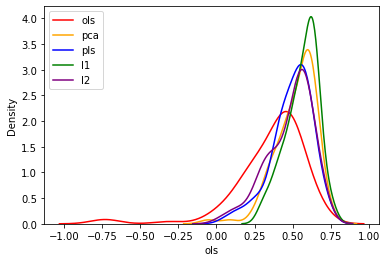

In [33]:
sns.kdeplot(results["ols"], c="red", label="ols")
sns.kdeplot(results["pca"], c="orange", label="pca")
sns.kdeplot(results["pls"], c="blue", label="pls")
sns.kdeplot(results["l1"], c="green", label="l1")
sns.kdeplot(results["l2"], c="purple", label="l2")
plt.legend(loc="upper left")
plt.show()

In [66]:
coef.describe()

,BiologicalMaterial01,BiologicalMaterial02,BiologicalMaterial03,BiologicalMaterial04,BiologicalMaterial05,BiologicalMaterial06,BiologicalMaterial08,BiologicalMaterial09,BiologicalMaterial10,BiologicalMaterial11,...,ManufacturingProcess36,ManufacturingProcess37,ManufacturingProcess38,ManufacturingProcess39,ManufacturingProcess40,ManufacturingProcess41,ManufacturingProcess42,ManufacturingProcess43,ManufacturingProcess44,ManufacturingProcess45
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.002519,0.003734,0.077644,-0.001816,0.037340,0.016404,0.003858,-0.007008,-0.018214,-0.003298,...,-0.034865,-0.091641,0.001289,0.089939,-0.000005,0.001614,-0.002286,0.007470,-0.007601,0.019646
std,0.013755,0.028534,0.068232,0.017274,0.041931,0.032850,0.020881,0.020983,0.028068,0.012547,...,0.041048,0.056506,0.012153,0.050923,0.016207,0.010010,0.014098,0.020886,0.018033,0.025435
min,-0.083677,-0.096864,-0.020855,-0.172703,-0.033653,0.000000,-0.012103,-0.114675,-0.096031,-0.085341,...,-0.132735,-0.211461,-0.046809,0.000000,-0.074344,-0.022855,-0.067514,-0.000000,-0.091722,-0.000291
25%,0.000000,0.000000,0.018269,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.025281,0.000000,...,-0.061078,-0.129722,0.000000,0.058918,0.000000,0.000000,0.000000,0.000000,-0.004780,0.000000
50%,0.000000,0.000000,0.076225,0.000000,0.026428,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.029144,-0.096958,0.000000,0.101220,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.003526
75%,0.000000,0.000000,0.118550,0.000000,0.068538,0.011962,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.047966,0.000000,0.124879,0.000000,0.000000,0.000000,0.000000,0.000000,0.037830
max,0.027605,0.159679,0.300144,-0.000000,0.188148,0.133320,0.163609,-0.000000,-0.000000,0.001054,...,0.122598,-0.000000,0.044463,0.212362,0.056909,0.079505,0.049475,0.111851,0.012416,0.111062


In [34]:
normalised_ds = (ds-ds.mean())/ds.std()

In [61]:
trials = 100
results = pd.DataFrame()
model = linear_model.Lasso
scores = []
coef = pd.DataFrame()

for i in range(trials):
    train_val, test = train_test_split(normalised_ds, test_size=0.2, random_state=i+trials)
    train, val = train_test_split(train_val, test_size=0.25, random_state=i+trials*2)
    ds_ = {}
    ds_["x_train"] = train.drop(columns="Yield")
    ds_["x_val"] = val.drop(columns="Yield")
    ds_["x_train_val"] = train_val.drop(columns="Yield")
    ds_["x_test"] = test.drop(columns="Yield")
    ds_["y_train"] = train["Yield"]
    ds_["y_val"] = val["Yield"]
    ds_["y_train_val"] = train_val["Yield"]
    ds_["y_test"] = test["Yield"]
    
    s = []
    alphas = [10**(i/4) for i in range(-30, 0)]
    for alpha in alphas:
        penalised_reg = model(alpha=alpha, max_iter=10_000)
        penalised_reg.fit(ds_["x_train"], ds_["y_train"])
        s.append(penalised_reg.score(ds_["x_val"], ds_["y_val"]))

    best_alpha = alphas[s.index(max(s))]
    final_model = model(alpha=best_alpha, max_iter=10_000)
    final_model.fit(ds_["x_train_val"], ds_["y_train_val"])
    scores.append(final_model.score(ds_["x_test"], ds_["y_test"]))
    c = pd.DataFrame(final_model.coef_.reshape(1,-1), columns=ds_["x_train_val"].columns)
    coef = pd.concat([coef, c])


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5064773226829624, tolerance: 0.010985351617411473
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5065187757139338, tolerance: 0.010985351617411473
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5065684677319897, tolerance: 0.010985351617411473
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coor

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20733000864172446, tolerance: 0.009731595725608085
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20738129656751347, tolerance: 0.009731595725608085
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20747241135419436, tolerance: 0.009731595725608085
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6778439323586731, tolerance: 0.010257341257437425
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6780333740076365, tolerance: 0.010257341257437425
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6783704207049643, tolerance: 0.010257341257437425
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coor

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3899326794403457, tolerance: 0.00880053810817226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.38994449770224193, tolerance: 0.00880053810817226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.38996717099570866, tolerance: 0.00880053810817226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.518585285872815, tolerance: 0.011317069719947854
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5186610743281825, tolerance: 0.011317069719947854
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5187952970274452, tolerance: 0.011317069719947854
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26084841343855025, tolerance: 0.009634307324759925
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26148472129456124, tolerance: 0.009634307324759925
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3341045046954356, tolerance: 0.010736633815890309
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_co

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.519362871562409, tolerance: 0.010786036569599282
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5195561339918218, tolerance: 0.010786036569599282
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.519898702230245, tolerance: 0.010786036569599282
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordi

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9820477615581584, tolerance: 0.011964763847517998
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9825770796610627, tolerance: 0.011964763847517998
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9835111758020858, tolerance: 0.011964763847517998
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coor

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9317138891090959, tolerance: 0.00921109682604133
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9318509618098254, tolerance: 0.00921109682604133
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9320934408965993, tolerance: 0.00921109682604133
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5507251919913987, tolerance: 0.011090931208078511
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5507659869010624, tolerance: 0.011090931208078511
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.550838492885589, tolerance: 0.011090931208078511
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15418433458539837, tolerance: 0.011874695569986285
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4987605894402947, tolerance: 0.01054557249433361
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.49877639139026, tolerance: 0.01054557249433361
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17870675038593653, tolerance: 0.011134100192587601
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17898424088171971, tolerance: 0.011134100192587601
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1794729896688434, tolerance: 0.011134100192587601
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_co

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6032907873369702, tolerance: 0.009084926534033222
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6033733209528584, tolerance: 0.009084926534033222
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8494032641508884, tolerance: 0.010876636438320687
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coor

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7812853032608427, tolerance: 0.010230009630896637
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.607671838621279, tolerance: 0.010230009630896637
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.608975344418365, tolerance: 0.010230009630896637
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordi

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.42862908638051067, tolerance: 0.010957049293168666
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4287309121395335, tolerance: 0.010957049293168666
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.42891128454377814, tolerance: 0.010957049293168666
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_co

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4694930548492007, tolerance: 0.011833344686616665
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4696692573444192, tolerance: 0.011833344686616665
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4699833928608985, tolerance: 0.011833344686616665
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coor

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.141063521857948, tolerance: 0.009882881143183005
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1412101814767048, tolerance: 0.009882881143183005
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1414706823750045, tolerance: 0.009882881143183005
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9524869844783819, tolerance: 0.01204951548624779
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9538070107501735, tolerance: 0.01204951548624779
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13236868388512413, tolerance: 0.010803116152230494
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12241042342159325, tolerance: 0.00954340288285978
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1224184350592914, tolerance: 0.00954340288285978
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12242809835894342, tolerance: 0.00954340288285978
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1101019460745896, tolerance: 0.009503392635901662
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1101155722506029, tolerance: 0.009503392635901662
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.110139711443475, tolerance: 0.009503392635901662
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.41115662201832137, tolerance: 0.011566634757159166
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.41116767384942676, tolerance: 0.011566634757159166
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4111864946358441, tolerance: 0.011566634757159166
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_co

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0532841755451248, tolerance: 0.009657306597732012
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.724611333811449, tolerance: 0.009601739634036384
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.72462625683632, tolerance: 0.009601739634036384
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7898079188544145, tolerance: 0.008326999393897564
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7911280611717277, tolerance: 0.008326999393897564
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4269905502373579, tolerance: 0.009839178945927
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordin

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15260610698870458, tolerance: 0.00945860746208501
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15315648522354586, tolerance: 0.00945860746208501
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9643017993157876, tolerance: 0.009390548133389413
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coor

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9837691421086863, tolerance: 0.010298124763526949
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9838465261977412, tolerance: 0.010298124763526949
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9839840531273705, tolerance: 0.010298124763526949
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coor

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7676343157190084, tolerance: 0.009465105936522295
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.768846687702877, tolerance: 0.009465105936522295
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3244859971800711, tolerance: 0.009465105936522295
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1468073827223666, tolerance: 0.009768409044546884
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14708054376092505, tolerance: 0.009768409044546884
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14756300430696534, tolerance: 0.009768409044546884
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_co

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2402015576512753, tolerance: 0.011686362881906597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2402140189586284, tolerance: 0.011686362881906597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.240236268537128, tolerance: 0.011686362881906597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3592311962266734, tolerance: 0.011887464997607995
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3592436517298445, tolerance: 0.011887464997607995
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.359265403213989, tolerance: 0.011887464997607995
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1871395767024557, tolerance: 0.011018942622573078
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1873016984974054, tolerance: 0.011018942622573078
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.18758815472939, tolerance: 0.011018942622573078
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordi

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0741895614553432, tolerance: 0.01069782285028663
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0743476256817797, tolerance: 0.01069782285028663
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.074627243071431, tolerance: 0.01069782285028663
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.48549888586249423, tolerance: 0.010111860399640682
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.48641160383192705, tolerance: 0.010111860399640682
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4879775020936563, tolerance: 0.010111860399640682
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_co

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4932995532223323, tolerance: 0.009198146175421213
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4934754729480222, tolerance: 0.009198146175421213
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4937861923030038, tolerance: 0.009198146175421213
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coor

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0984550439914162, tolerance: 0.010407604255226546
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0984708214168322, tolerance: 0.010407604255226546
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0984951274068049, tolerance: 0.010407604255226546
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coor

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24493383008542935, tolerance: 0.011145275629460955
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2448733633405915, tolerance: 0.011145275629460955
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24484628458658975, tolerance: 0.011145275629460955
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_co

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5515579088780882, tolerance: 0.009657362010256364
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5516502463677835, tolerance: 0.009657362010256364
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5518141703846275, tolerance: 0.009657362010256364
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coor

In [65]:
ols = linear_model.LinearRegression()
ols.fit(X=ds_["x_train"], y=ds_["y_train"])
ols.score(X=ds_["x_val"], y=ds_["y_val"])

-12.796017244653346

In [69]:
coef.describe().T.sort_values("mean")

,count,mean,std,min,25%,50%,75%,max
ManufacturingProcess17,100.0,-0.092604,0.063208,-0.239935,-0.142785,-0.095638,-0.035055,-0.000000
ManufacturingProcess37,100.0,-0.091641,0.056506,-0.211461,-0.129722,-0.096958,-0.047966,-0.000000
ManufacturingProcess13,100.0,-0.091593,0.061049,-0.354689,-0.121917,-0.090764,-0.050403,-0.000000
ManufacturingProcess28,100.0,-0.066639,0.063579,-0.199702,-0.110284,-0.066944,0.000000,-0.000000
ManufacturingProcess33,100.0,-0.066482,0.113962,-0.407926,-0.105270,0.000000,0.000000,-0.000000
ManufacturingProcess36,100.0,-0.034865,0.041048,-0.132735,-0.061078,-0.029144,0.000000,0.122598
ManufacturingProcess07,100.0,-0.033551,0.034317,-0.139337,-0.055836,-0.027913,0.000000,-0.000000
BiologicalMaterial10,100.0,-0.018214,0.028068,-0.096031,-0.025281,0.000000,0.000000,-0.000000
ManufacturingProcess35,100.0,-0.015290,0.023888,-0.110603,-0.030660,-0.000000,0.000000,-0.000000
ManufacturingProcess24,100.0,-0.014478,0.022024,-0.107413,-0.026131,-0.000000,0.000000,0.027449


In [64]:
for i, a in enumerate([10**(i/4) for i in range(-30, 0)]):
    print(f"{a:.4e}", s[i])

3.1623e-08 -2.2588790316614005
5.6234e-08 -2.258780810747717
1.0000e-07 -2.2586061513629456
1.7783e-07 -2.258295573489865
3.1623e-07 -2.2577433276848744
5.6234e-07 -2.2567614334914823
1.0000e-06 -2.2550158355715304
1.7783e-06 -2.2519132062464964
3.1623e-06 -2.246400707473082
5.6234e-06 -2.2366132595487893
1.0000e-05 -2.219256873156001
1.7783e-05 -2.1883777053285685
3.1623e-05 -2.133744019681678
5.6234e-05 -2.036175533762111
1.0000e-04 -1.8710107553093396
1.7783e-04 -1.5932033944748007
3.1623e-04 -1.1279223147751498
5.6234e-04 -0.4963081913353775
1.0000e-03 0.06590397050737262
1.7783e-03 0.2643739958540504
3.1623e-03 0.36690536145077113
5.6234e-03 0.45675757857693655
1.0000e-02 0.5420870462827645
1.7783e-02 0.5660789937706374
3.1623e-02 0.5911141919443721
5.6234e-02 0.5784266597941705
1.0000e-01 0.5757917631715064
1.7783e-01 0.5615071768370105
3.1623e-01 0.4468203942542093
5.6234e-01 0.09774498699006284
